# Detección de anomalias usando Autoencoders

Referencia [link](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Datos

Usaremos el conjunto de datos [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/boltzmannbrain/nab). Este proporciona series de tiempo artificiales que contienen períodos anómalos de comportamiento etiquetados. Los datos están ordenados, tienen marcas de tiempo y son métricas de un solo valor.

Usaremos el archivo `art_daily_small_noise.csv` para el entrenamiento y el archivo `art_daily_jumpsup.csv` para las pruebas. La simplicidad de este conjunto de datos nos permite demostrar la detección de anomalías de manera efectiva.



In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [ ]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [ ]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## Visualización de los datos

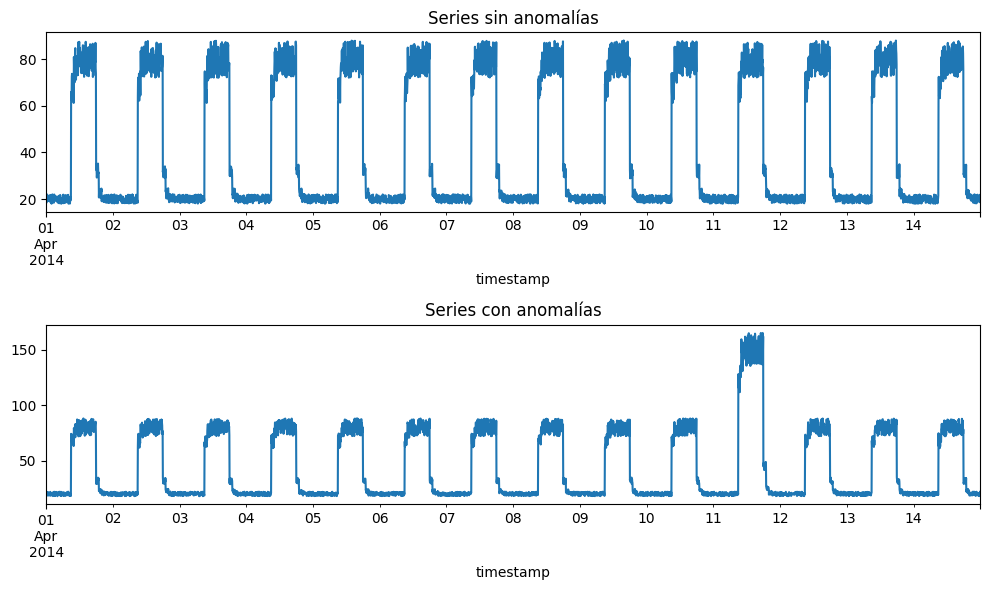

In [ ]:
# Visualización de series de tiempo
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
df_small_noise.plot(legend=False, ax=ax[0], title="Series sin anomalías")
df_daily_jumpsup.plot(legend=False, ax=ax[1], title="Series con anomalías")
plt.tight_layout()
plt.show()

## Preprocesado

Obtenemos los valores del archivo de datos de la serie de tiempo de entrenamiento y normalizamos los datos de `value`. Tenemos un `value` cada 5 minutos durante 14 días.

* 24 * 60 / 5 = **288 pasos de tiempo por día**
* 288 * 14 = **4032 puntos de datos** en total"


In [ ]:
# Preprocesado de series de tiempo
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Número de ejemplos de entrenamiento:", len(df_training_value))

Número de ejemplos de entrenamiento: 4032


## Creación de dataset

In [ ]:
TIME_STEPS = 288

# Creación de secuencias
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)
print("Shape entrenamiento: ", x_train.shape)

Shape entrenamiento:  (3745, 288, 1)


## Construcción de modelos

In [ ]:
# Autoencoder LSTM
lstm_autoencoder = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(64, activation="tanh", return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation="tanh", return_sequences=True),
    Dropout(0.2),
    LSTM(16, activation="tanh", return_sequences=False),
    RepeatVector(x_train.shape[1]),
    LSTM(32, activation="tanh", return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation="tanh", return_sequences=True),
    TimeDistributed(Dense(x_train.shape[2]))
])

lstm_autoencoder.compile(
    optimizer=Adam(learning_rate=5e-3),
    loss="mse",
)

lstm_autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 288, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 288, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 288, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 288, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 288, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 288, 32)        │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 288, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 288, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 288, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,617 (248.50 KB)

 Trainable params: 63,617 (248.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Autoencoder convolucional
conv_autoencoder = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    Conv1D(
        filters=32,
        kernel_size=7,
        padding="same",
        strides=2,
        activation="relu",
    ),
    Dropout(rate=0.2),
    Conv1D(
        filters=16,
        kernel_size=7,
        padding="same",
        strides=2,
        activation="relu",
    ),
    Dropout(rate=0.2),
    Conv1DTranspose(
        filters=16,
        kernel_size=7,
        padding="same",
        strides=2,
        activation="relu",
    ),
    Dropout(rate=0.2),
    Conv1DTranspose(
        filters=32,
        kernel_size=7,
        padding="same",
        strides=2,
        activation="relu",
    ),
    Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
])

conv_autoencoder.compile(
    optimizer=Adam(learning_rate=5e-3),
    loss="mse",
)

conv_autoencoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 72, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 288, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [ ]:
# Entrenamiento autoencoder LSTM
history_1 = lstm_autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 249ms/step - loss: 0.9969 - val_loss: 0.9851
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.9729 - val_loss: 0.9704
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.9745 - val_loss: 0.9825
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.9760 - val_loss: 0.9874
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.9719 - val_loss: 0.9846
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.9664 - val_loss: 0.9628
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.9560 - val_loss: 0.9927
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.9856 - val_loss: 1.0064
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.9751 - val_loss: 0.9109
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.8767 - val_loss: 0.8476
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.8280 - val_loss: 0.7211
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 

In [ ]:
# Entrenamiento autoencoder convolucional
history_2 = conv_autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - loss: 0.4779 - val_loss: 0.0673
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0681 - val_loss: 0.0435
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0435 - val_loss: 0.0365
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333 - val_loss: 0.0338
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0282 - val_loss: 0.0258
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 - val_loss: 0.0203
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0226 - val_loss: 0.0189
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0212 - val_loss: 0.0157
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0200 - val_loss: 0.0164
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0190 - val_loss: 0.0151
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0180 - val_loss: 0.0130
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0173 - va

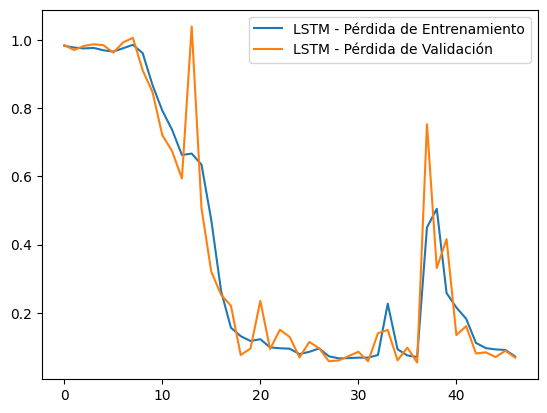

In [ ]:
# Gráfica autoencoder LSTM
plt.plot(history_1.history["loss"], label="LSTM - Pérdida de Entrenamiento")
plt.plot(history_1.history["val_loss"], label="LSTM - Pérdida de Validación")
plt.legend()
plt.show()

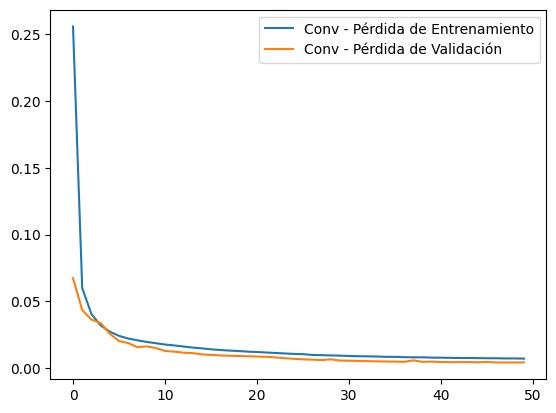

In [ ]:
# Gráfica autoencoder convolucional
plt.plot(history_2.history["loss"], label="Conv - Pérdida de Entrenamiento")
plt.plot(history_2.history["val_loss"], label="Conv - Pérdida de Validación")
plt.legend()
plt.show()

## Detectando anomalías

Detectaremos anomalías determinando qué tan bien nuestro modelo puede reconstruir los datos de entrada.

1. Calcular la pérdida MAE en las muestras de entrenamiento.
2. Encontrar el valor máximo de la pérdida MAE. Este es el peor desempeño de nuestro modelo al intentar reconstruir una muestra. Usaremos este valor como el `umbral` para la detección de anomalías.
3. Si la pérdida de reconstrucción para una muestra es mayor que este valor `umbral`, entonces podemos inferir que el modelo está observando un patrón con el que no está familiarizado. Etiquetaremos esta muestra como una `anomalía`.


In [ ]:
# Obtenemos el MAE.
def calculate_mae(model, x_data, mode="entrenamiento"):
    x_data_pred = model.predict(x_data)
    mae_loss = np.mean(np.abs(x_data_pred - x_data), axis=1)
    plt.hist(mae_loss, bins=50)
    plt.xlabel("MAE de {}".format(mode))
    plt.ylabel("Número de muestras")
    plt.show()
    threshold = np.max(mae_loss)
    return x_data_pred, threshold, mae_loss

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step


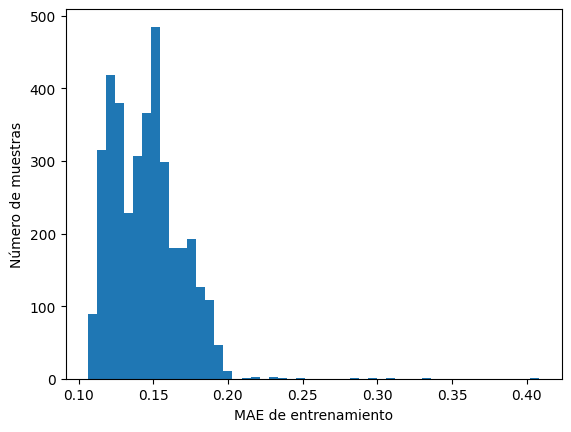

In [ ]:
lstm_train_pred, lstm_threshold, _ = calculate_mae(lstm_autoencoder, x_train)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


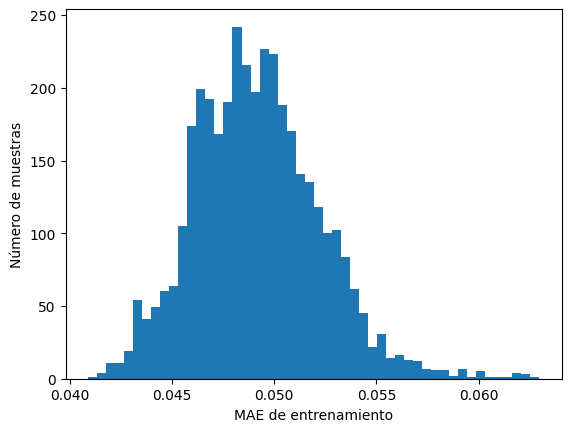

In [ ]:
conv_train_pred, conv_threshold, _ = calculate_mae(conv_autoencoder, x_train)

### Comparar reconstrucción

Veamos cómo nuestro modelo ha reconstruido la primera muestra.
Esta corresponde a los **288 pasos de tiempo del día 1** de nuestro conjunto de entrenamiento.



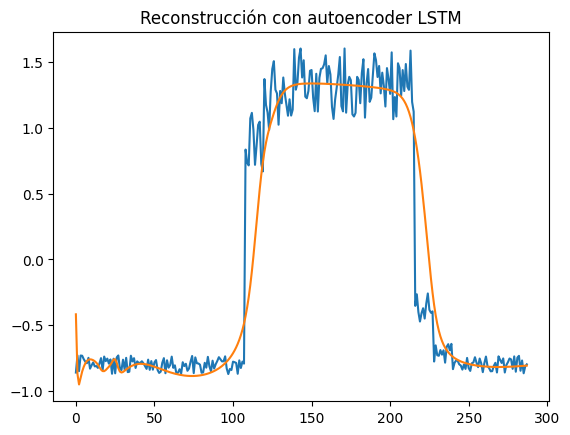

In [ ]:
plt.plot(x_train[0])
plt.plot(lstm_train_pred[0])
plt.title("Reconstrucción con autoencoder LSTM")
plt.show()

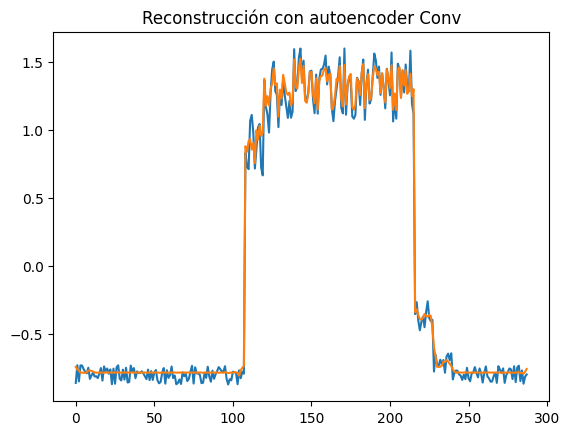

In [ ]:
plt.plot(x_train[0])
plt.plot(conv_train_pred[0])
plt.title("Reconstrucción con autoencoder Conv")
plt.show()

### Preparación de los datos test

In [ ]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
x_test = create_sequences(df_test_value.values)
print("Shape testeo: ", x_test.shape)

Shape testeo:  (3745, 288, 1)


## Métricas de autoencoders

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


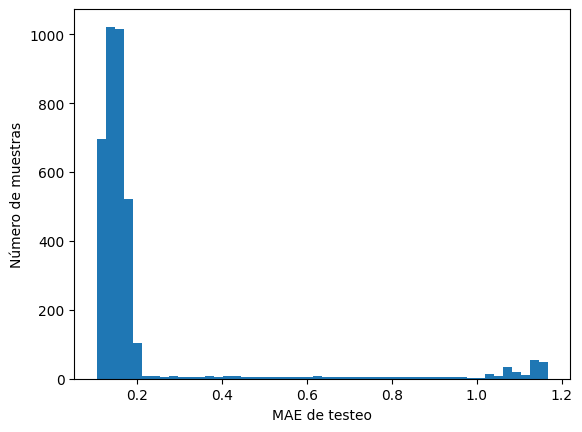

Número de muestras anómalas:  330


In [ ]:
lstm_test_pred, _, lstm_test_mae = calculate_mae(lstm_autoencoder, x_test, mode="testeo")
lstm_test_mae = lstm_test_mae.reshape((-1))
anomalies = lstm_test_mae > lstm_threshold
print("Número de muestras anómalas: ", np.sum(anomalies))

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


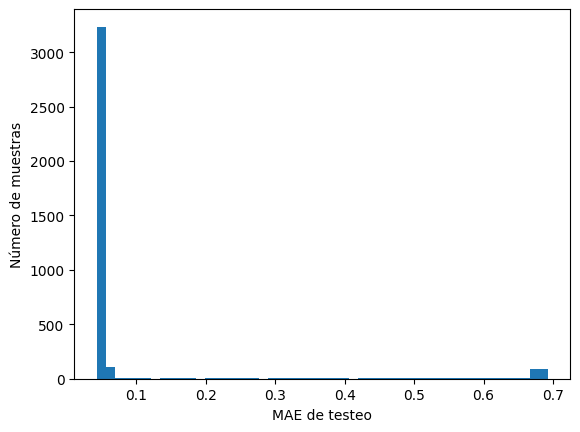

Número de muestras anómalas:  404


In [ ]:
conv_test_pred, _, conv_test_mae = calculate_mae(conv_autoencoder, x_test, mode="testeo")
conv_test_mae = conv_test_mae.reshape((-1))
anomalies = conv_test_mae > conv_threshold
print("Número de muestras anómalas: ", np.sum(anomalies))

El modelo autoencoder con capas convolucionales demuestra ser mucho mejor que aquel con capas LSTM, esto se observa de forma gráfica con el error absoluto medio de las predicciones en el conjunto de testeo y entrenamiento, con claras diferencias en la magnitud.
Además, al ser el autoencoder convolucional mejor en cuanto a su fiabilidad, es capaz de detectar un mayor número de anomalías.